We construct a graph where nodes are amino sequences, and edges connect sequences with levenshtein distance == 1.

For rigor, we limit the minimum sequence length to 20.

In [6]:
import networkx as nx
from itertools import combinations
import time
from pybktree import BKTree
import Levenshtein as lev  # Efficient Levenshtein distance computation
import numpy as np
import scipy.linalg as spla
from tqdm.notebook import tqdm  

# load "PDB Seqres.fasta"

with open("PDB Seqres.fasta", "r") as file:
    data = file.read()


proteins = data.split(">")[1:]
aminos = []
labels = []


for idx, protein in enumerate(proteins):
    try:
        aminos.append(protein.split("\n")[1])
        labels.append(protein.split("\n")[0])
    except:
        pass

# dedupe
aminos = list(set(aminos))
aminos = [amino for amino in aminos if "X" not in amino and len(amino) > 25]

n = 50000
aminos = aminos[:n]


def create_graph_bktree(aminos, k=1):
    """
    Create a graph where nodes are amino sequences and edges connect sequences with
    Levenshtein distance up to k, including insertions and deletions at the ends.

    Parameters:
    - aminos (list): List of amino acid sequences.
    - k (int): Maximum Levenshtein distance for edge creation.

    Returns:
    - G (networkx.Graph): The constructed graph.
    """
    G = nx.Graph()
    G.add_nodes_from(range(len(aminos)))  # Using indices as node identifiers

    # Build BK-tree using Levenshtein distance as the metric
    tree = BKTree(lev.distance, aminos)

    start_time = time.time()
    length = len(aminos)

    for idx, seq in tqdm(list(enumerate(aminos))):
        # Query for all sequences within distance k
        matches = tree.find(seq, k)
        for distance, match_seq in matches:
            neighbor_idx = aminos.index(match_seq)
            if neighbor_idx != idx:
                G.add_edge(idx, neighbor_idx)


    total_time = time.time() - start_time
    print(f"Total time for BK-tree graph creation: {total_time:.2f} seconds")
    return G


# Create the optimized graph with Hamming distance threshold k=2
graph = create_graph_bktree(aminos, k=1)
print(f"Number of nodes in the graph: {graph.number_of_nodes()}")
print(f"Number of edges in the graph: {graph.number_of_edges()}")


  0%|          | 0/50000 [00:00<?, ?it/s]

Total time for BK-tree graph creation: 15.68 seconds
Number of nodes in the graph: 50000
Number of edges in the graph: 3296


We lower bound sequence length to 20. As a result, we will assume that all of our proteins are 20 amino acids long. This is not true, but it is a good approximation for the purposes of this analysis.

Take an initial string $s$. We can then estimate the number of strings that are levenshtein distance 1 apart from $s$. This is approximately equal to 
$$
19 \times 20 + 20 \times 20 + 20 = 800
$$
These terms correspond to changing letters, inserting letters, and deleting letters respectively. We can then say that the probability of finding a string within Levenshtein distance 1 is given by 
$$
\frac{800}{20^{20}} \times 50000 \approx 0
$$

This means that it's quite cool that we see *any* connected components at all.

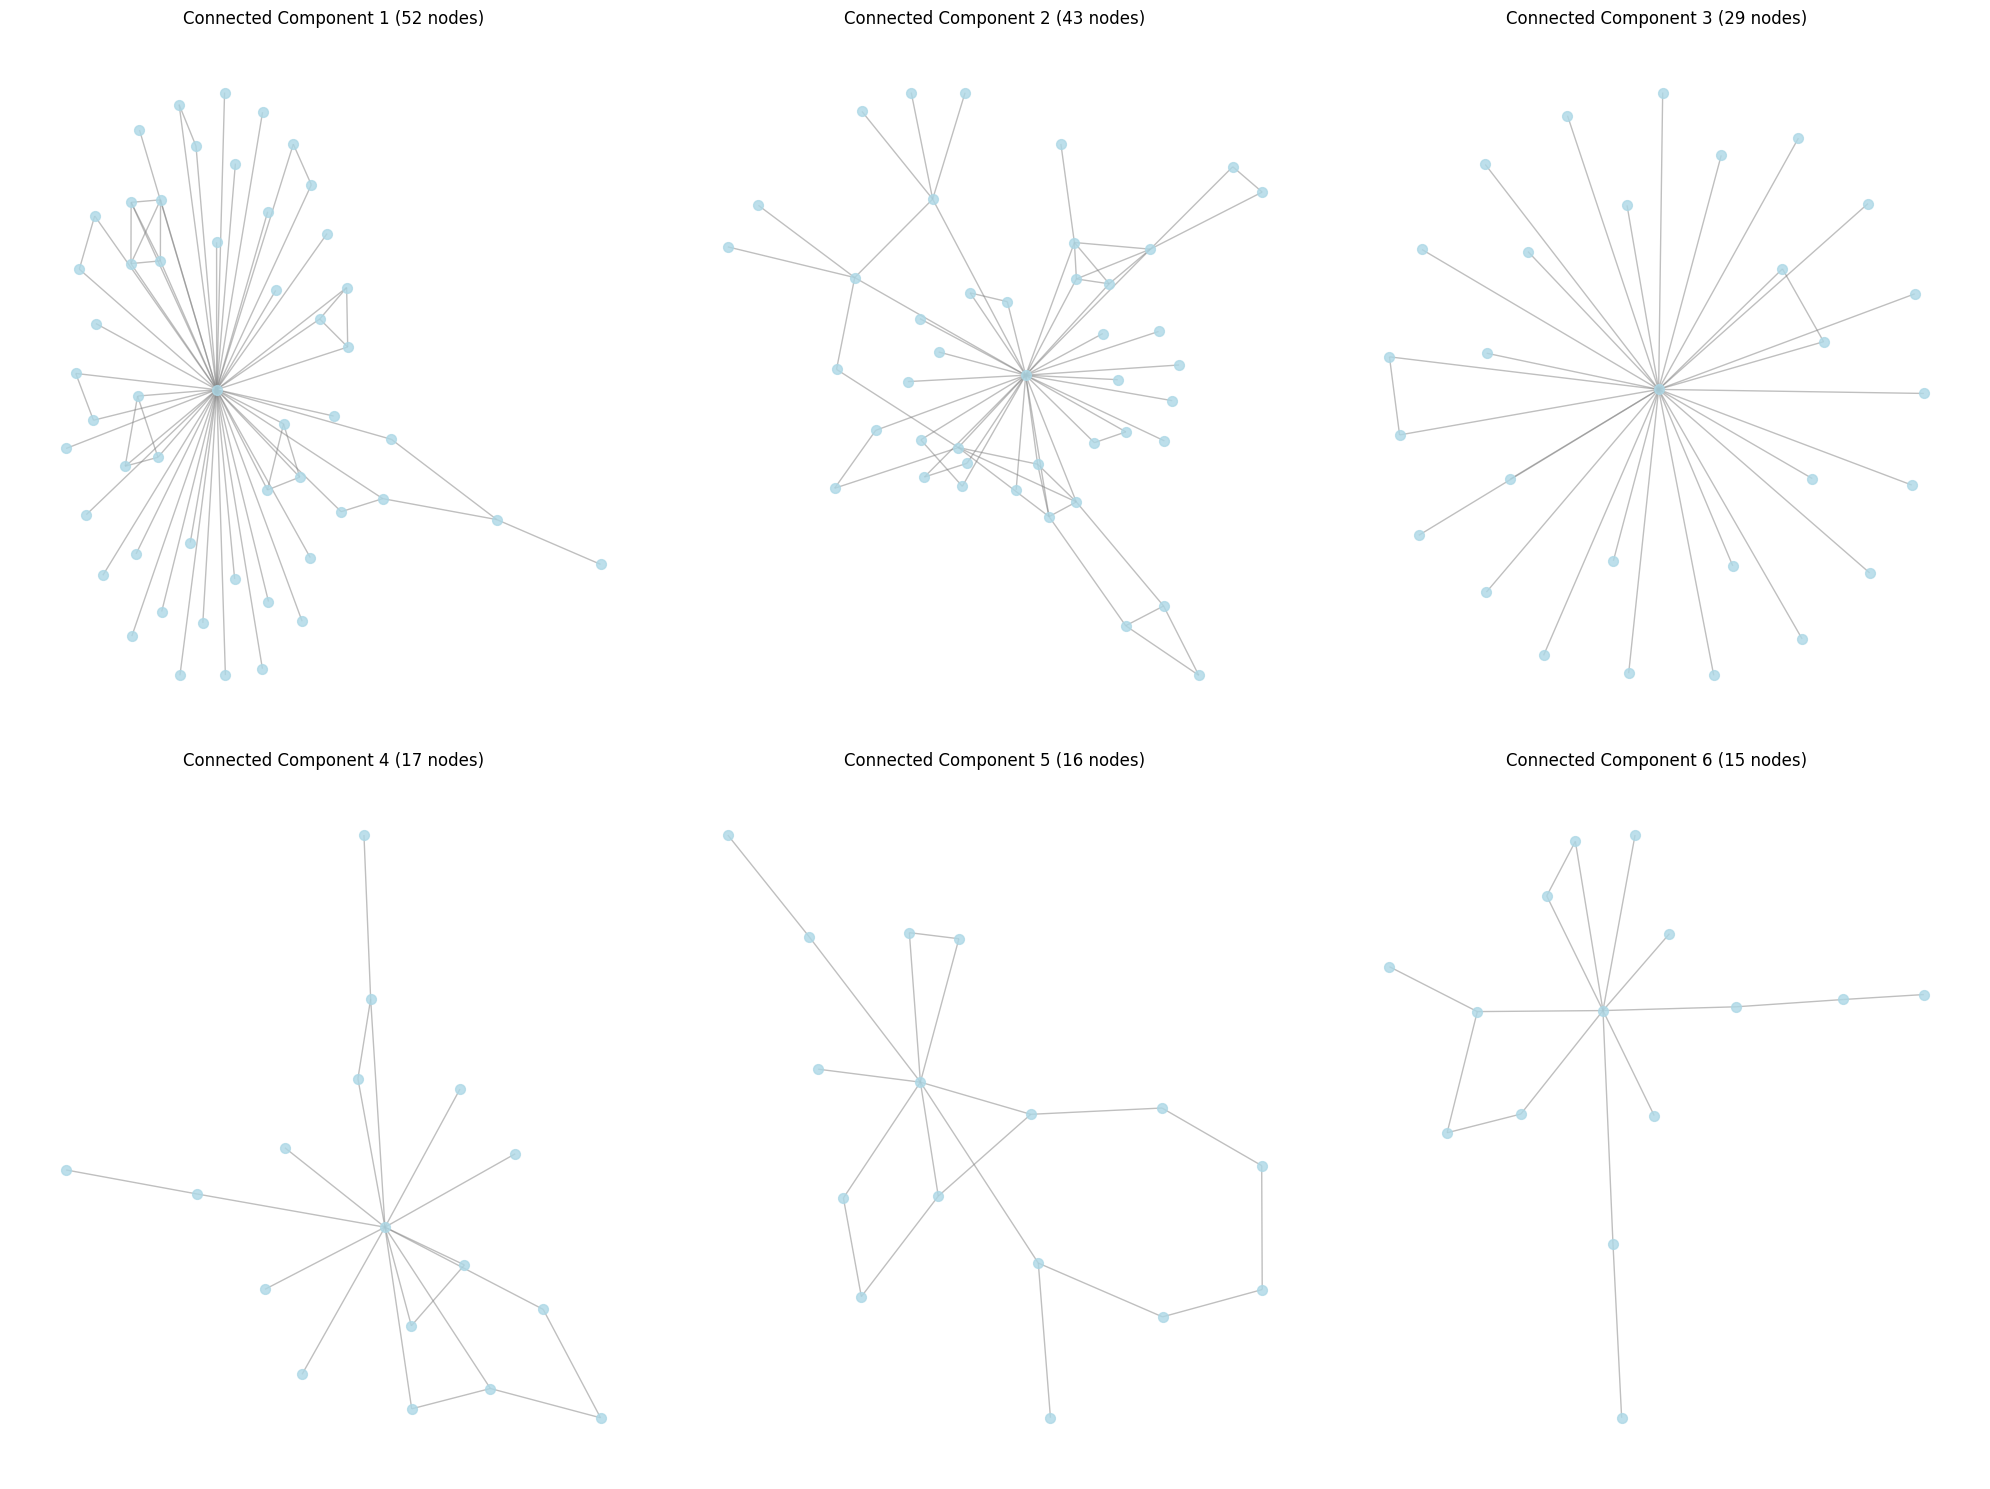

In [8]:
import matplotlib.pyplot as plt
from pprint import pprint

# Plot the 6 largest connected components
plt.figure(figsize=(20, 15))

# Get the 6 largest connected components
connected_components = sorted(nx.connected_components(graph), key=len, reverse=True)[:6]

for i, component in enumerate(connected_components, 1):
    plt.subplot(2, 3, i)
    subgraph = graph.subgraph(component)
    
    # Calculate layout for the subgraph
    pos = nx.spring_layout(subgraph)
    
    # Draw nodes
    nx.draw_networkx_nodes(subgraph, pos, node_size=50, node_color="lightblue", alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(subgraph, pos, edge_color="gray", alpha=0.5)
    
    # Set title and adjust layout
    plt.title(f"Connected Component {i} ({len(component)} nodes)")
    plt.axis("off")

plt.tight_layout()
plt.savefig("six_largest_connected_components.png", dpi=300, bbox_inches="tight")
plt.show()

# # Print information about the 6 largest connected components
# for i, component in enumerate(connected_components, 1):
#     print(f"Connected Component {i}: {len(component)} nodes")
#     # print the amino acids in the component
#     pprint(
#         f"Amino acids in the component: {sorted([aminos[node] for node in component])}"
#     )



From each 6 of our connected components, we can project all of our proteins into an embedding space using some embedding AI model. We can then PCA this space, and see if connected components in the original graph correspond to clusters in the PCA space.